In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr, pearsonr
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体显示
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置图形样式

plt.rcParams['figure.figsize'] = (14, 6)

# loading data

In [132]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
'month' in train.columns

False

# EDA
- 可视化初步分析预测目标分布
- 缺失特征分析
- 自相关性分析
- 特征分析


In [133]:
print(train.head(5))
print(f"训练集大小: {train.shape}, 测试集大小: {test.shape}")
print(train.dtypes)
print(f'时间范围: 从 {train["date_id"].min()} 到 {train["date_id"].max()}，共计 { len(train["date_id"])} 天')


   date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]
训练集大小: (9021, 98), 测试集大小: (10, 99)
date_id                            

In [134]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9021 entries, 0 to 9020
Data columns (total 98 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   date_id                        9021 non-null   int64  
 1   D1                             9021 non-null   int64  
 2   D2                             9021 non-null   int64  
 3   D3                             9021 non-null   int64  
 4   D4                             9021 non-null   int64  
 5   D5                             9021 non-null   int64  
 6   D6                             9021 non-null   int64  
 7   D7                             9021 non-null   int64  
 8   D8                             9021 non-null   int64  
 9   D9                             9021 non-null   int64  
 10  E1                             7237 non-null   float64
 11  E10                            8015 non-null   float64
 12  E11                            8015 non-null   f

In [135]:
print("\n" + "="*80)
print(" 目标变量分析 ")
print("="*80)
target = train['market_forward_excess_returns'].values
risk_free_rate = train['risk_free_rate'].values
forward_returns = train['forward_returns'].values

print(f"\n 目标变量统计:")
print(f"  平均值:     {target.mean():.6f} ({target.mean()*252*100:.2f}% 年化)")
print(f"  中位数:   {np.median(target):.6f}")
print(f"  标准差:      {target.std():.6f} ({target.std()*np.sqrt(252)*100:.2f}% 年化)")
print(f"  最小值:      {target.min():.6f}")
print(f"  最大值:      {target.max():.6f}")
print(f"  偏度: {stats.skew(target):.3f}")
print(f"  峰度: {stats.kurtosis(target):.3f} (excess)")
print(f"  缺失值数量: {np.sum(pd.isnull(target))}")

sharpe = (target.mean() / target.std()) * np.sqrt(252)
print(f"\n 基线夏普比率: {sharpe:.3f}")

print(f"\n return分布:")
print(f"  正收益天数: {(target > 0).sum()} ({(target > 0).sum()/len(target)*100:.1f}%)")
print(f"  负收益天数: {(target < 0).sum()} ({(target < 0).sum()/len(target)*100:.1f}%)")
print(f"  接近零 (<0.1%): {(np.abs(target) < 0.001).sum()}")

print(f"\n 极端事件 (>2倍标准差):")
extreme_positive = (target > target.mean() + 2*target.std()).sum()
extreme_negative = (target < target.mean() - 2*target.std()).sum()
print(f"  极端正收益天数: {extreme_positive} 天")
print(f"  极端负收益天数: {extreme_negative} 天")
print(f"  极端事件总数: {extreme_positive + extreme_negative} ({(extreme_positive + extreme_negative)/len(target)*100:.1f}%)")


 目标变量分析 

 目标变量统计:
  平均值:     0.000053 (1.34% 年化)
  中位数:   0.000255
  标准差:      0.010558 (16.76% 年化)
  最小值:      -0.040582
  最大值:      0.040551
  偏度: -0.180
  峰度: 2.244 (excess)
  缺失值数量: 0

 基线夏普比率: 0.080

 return分布:
  正收益天数: 4662 (51.7%)
  负收益天数: 4359 (48.3%)
  接近零 (<0.1%): 1086

 极端事件 (>2倍标准差):
  极端正收益天数: 229 天
  极端负收益天数: 320 天
  极端事件总数: 549 (6.1%)


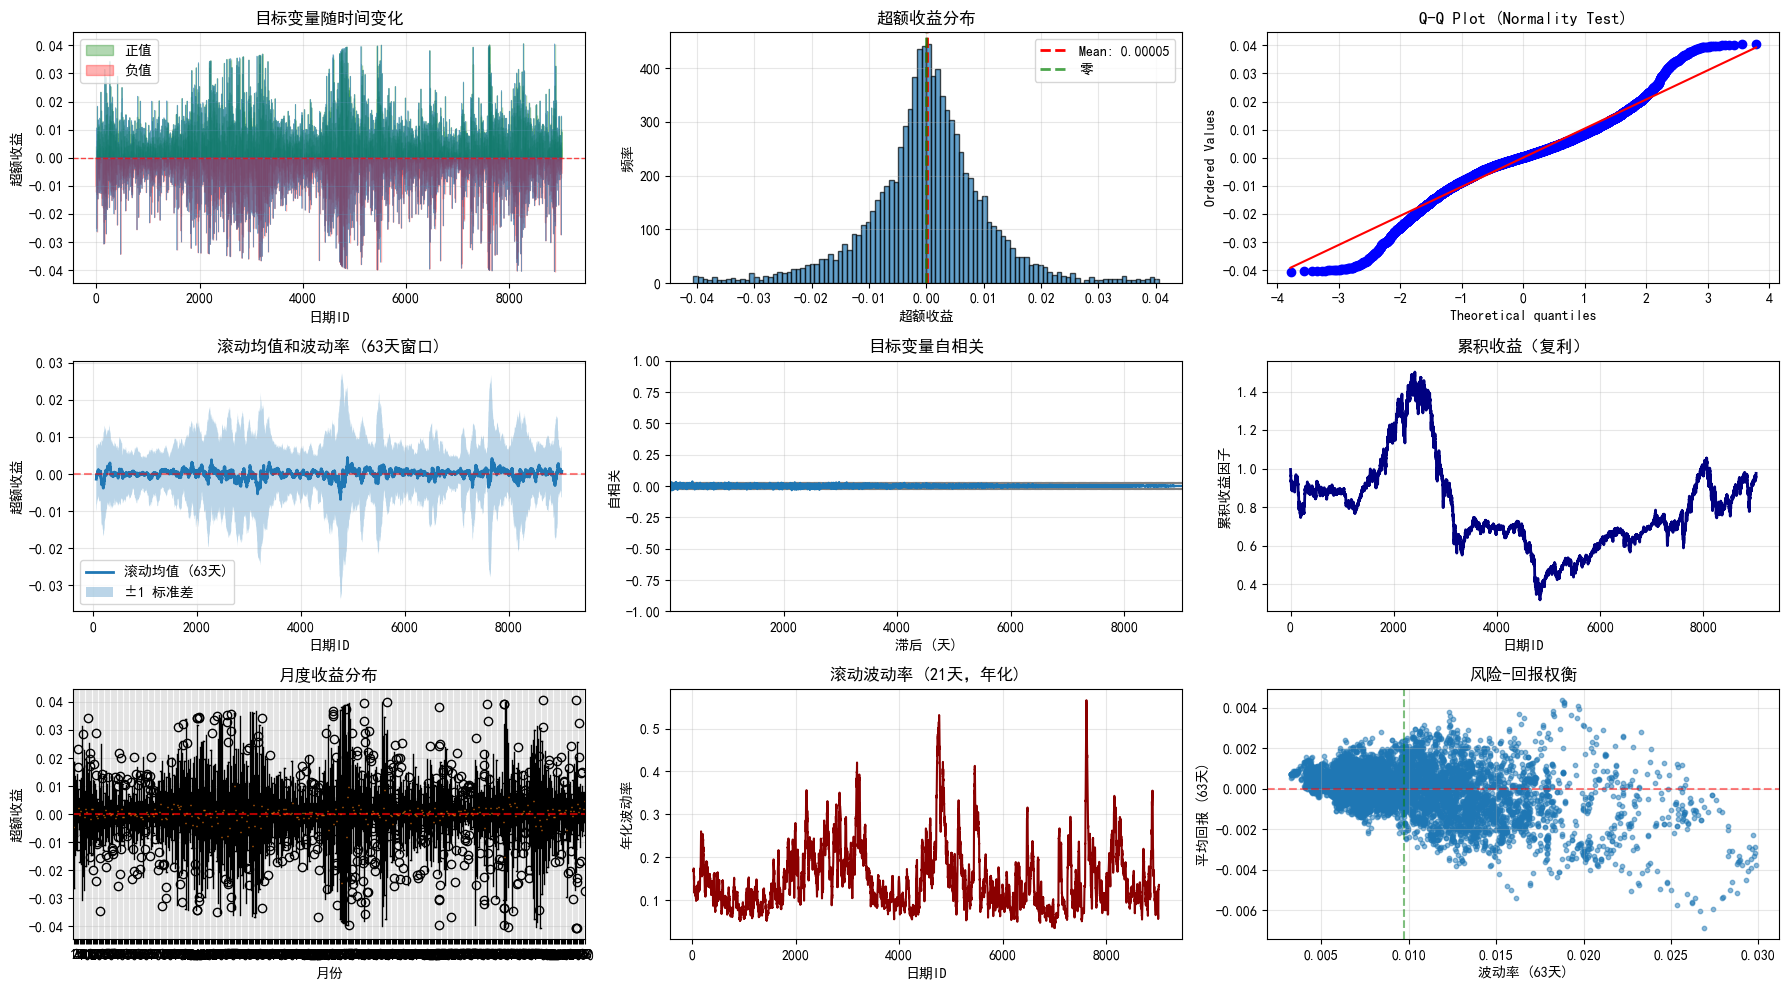

In [136]:
fig = plt.figure(figsize=(18, 10))

# 时间序列图
ax1 = plt.subplot(3, 3, 1)
plt.plot(train['date_id'], target, alpha=0.6, linewidth=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=1, alpha=0.7)
plt.fill_between(train['date_id'], 0, target, where=(target>0), alpha=0.3, color='green', label='正值')
plt.fill_between(train['date_id'], 0, target, where=(target<0), alpha=0.3, color='red', label='负值')
plt.title('目标变量随时间变化', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('超额收益')
plt.legend()
plt.grid(True, alpha=0.3)

# 分布直方图
ax2 = plt.subplot(3, 3, 2)
plt.hist(target, bins=100, edgecolor='black', alpha=0.7)
plt.axvline(target.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {target.mean():.5f}')
plt.axvline(0, color='green', linestyle='--', linewidth=2, alpha=0.7, label='零')
plt.title('超额收益分布', fontsize=12, fontweight='bold')
plt.xlabel('超额收益')
plt.ylabel('频率')
plt.legend()
plt.grid(True, alpha=0.3)

# Q-Q图（正态性检验）
ax3 = plt.subplot(3, 3, 3)
stats.probplot(target, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normality Test)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)

# 滚动均值和标准差
ax4 = plt.subplot(3, 3, 4)
rolling_mean = pd.Series(target).rolling(window=63).mean()  # ~3个月
rolling_std = pd.Series(target).rolling(window=63).std()
plt.plot(train['date_id'], rolling_mean, label='滚动均值 (63天)', linewidth=2)
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.fill_between(train['date_id'], rolling_mean - rolling_std, rolling_mean + rolling_std,
                 alpha=0.3, label='±1 标准差')
plt.title('滚动均值和波动率 (63天窗口)', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('超额收益')
plt.legend()
plt.grid(True, alpha=0.3)

# 自相关
ax5 = plt.subplot(3, 3, 5)
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(pd.Series(target))
plt.title('目标变量自相关', fontsize=12, fontweight='bold')
plt.xlabel('滞后 (天)')
plt.ylabel('自相关')
plt.grid(True, alpha=0.3)

# 累积收益
ax6 = plt.subplot(3, 3, 6)
cumulative_returns = (1 + pd.Series(target)).cumprod()
plt.plot(train['date_id'], cumulative_returns, linewidth=2, color='navy')
plt.title('累积收益（复利）', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('累积收益因子')
plt.grid(True, alpha=0.3)

# 月度收益箱线图
ax7 = plt.subplot(3, 3, 7)
  # 近似月份
month_data = train.copy()
month_data['month'] = train['date_id'] // 21
monthly_data = month_data.groupby('month')['market_forward_excess_returns'].apply(list)
plt.boxplot([m for m in monthly_data if len(m) > 0], showfliers=True)
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.title('月度收益分布', fontsize=12, fontweight='bold')
plt.xlabel('月份')
plt.ylabel('超额收益')
plt.grid(True, alpha=0.3)

# 波动率随时间变化
ax8 = plt.subplot(3, 3, 8)
rolling_vol = pd.Series(target).rolling(window=21).std()  # ~1个月
plt.plot(train['date_id'], rolling_vol * np.sqrt(252), linewidth=1.5, color='darkred')
plt.title('滚动波动率 (21天，年化)', fontsize=12, fontweight='bold')
plt.xlabel('日期ID')
plt.ylabel('年化波动率')
plt.grid(True, alpha=0.3)

# 回报率与波动率的散点图
ax9 = plt.subplot(3, 3, 9)
window = 63
rolling_ret = pd.Series(target).rolling(window=window).mean()
rolling_vol = pd.Series(target).rolling(window=window).std()
plt.scatter(rolling_vol, rolling_ret, alpha=0.5, s=10)
plt.xlabel('波动率 (63天)')
plt.ylabel('平均回报 (63天)')
plt.title('风险-回报权衡', fontsize=12, fontweight='bold')
plt.axhline(0, color='red', linestyle='--', alpha=0.5)
plt.axvline(rolling_vol.mean(), color='green', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()


 特征组摘要:
组别       数量       缺失比例(%)      描述
--------------------------------------------------------------------------------
D        9        0.0          Categorical/Binary Regime Indicators
E        20       15.2         Economic Indicators
I        9        11.2         Interest Rate Features
M        18       25.4         Market Features
P        13       12.7         Price/Performance Features
S        12       20.2         Sentiment Features
V        13       19.8         Volatility Features

 缺失数据摘要:
  总特征数: 94
  存在缺失值的特征数: 85
  缺失比例超过50%的特征数: 8
  缺失比例超过80%的特征数: 0

 缺失比例最高的10个特征:
feature  missing_count  missing_pct  first_valid_idx group
     E7           6969    77.253076             6969     E
    V10           6049    67.054650             6049     V
     S3           5733    63.551713             5733     S
     M1           5547    61.489857             5547     M
    M13           5540    61.412260             5540     M
    M14           5540    61.412260             5540

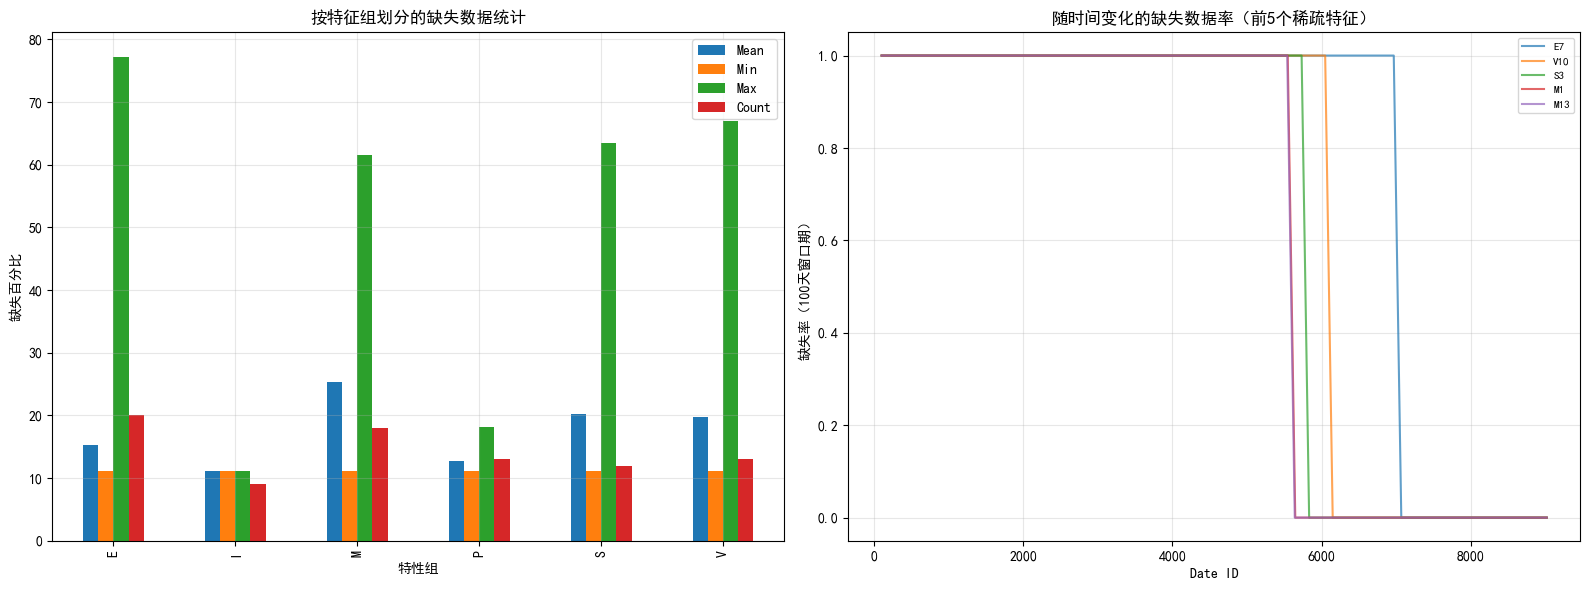

In [138]:
# 缺失值分析与可视化
feature_groups = {}
for prefix in ['D', 'E', 'I', 'M', 'P', 'S', 'V']:
    cols = [c for c in train.columns if c.startswith(prefix)]
    feature_groups[prefix] = cols

group_descriptions = {
    'D': 'Categorical/Binary Regime Indicators',
    'E': 'Economic Indicators',
    'I': 'Interest Rate Features',
    'M': 'Market Features',
    'P': 'Price/Performance Features',
    'S': 'Sentiment Features',
    'V': 'Volatility Features'
}

print(f"\n 特征组摘要:")
print(f"{'组别':<8} {'数量':<8} {'缺失比例(%)':<12} {'描述'}")
print("-" * 80)

for prefix, cols in feature_groups.items():
    if len(cols) > 0:
        missing_pct = train[cols].isnull().sum().sum() / (len(train) * len(cols)) * 100
        print(f"{prefix:<8} {len(cols):<8} {missing_pct:<12.1f} {group_descriptions[prefix]}")

# Calculate missing percentages
missing_analysis = []
for col in train.columns:
    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']:
        missing_count = train[col].isnull().sum()
        if missing_count > 0:
            missing_pct = missing_count / len(train) * 100
            # When does missing data appear?
            first_non_null = train[col].first_valid_index()
            missing_analysis.append({
                'feature': col,
                'missing_count': missing_count,
                'missing_pct': missing_pct,
                'first_valid_idx': first_non_null,
                'group': col[0]
            })

missing_df = pd.DataFrame(missing_analysis).sort_values('missing_pct', ascending=False)

print(f"\n 缺失数据摘要:")
print(f"  总特征数: {len([c for c in train.columns if c not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']])}")
print(f"  存在缺失值的特征数: {len(missing_df)}")
print(f"  缺失比例超过50%的特征数: {(missing_df['missing_pct'] > 50).sum()}")
print(f"  缺失比例超过80%的特征数: {(missing_df['missing_pct'] > 80).sum()}")

print(f"\n 缺失比例最高的10个特征:")
print(missing_df.head(10).to_string(index=False))

# 按组计算缺失统计并可视化（按前缀分组）
group_stats = []
for prefix, cols in feature_groups.items():
    if len(cols) == 0:
        continue
    cols = [c for c in cols if c in train.columns]
    total_cells = len(train) * len(cols)
    total_missing = train[cols].isnull().sum().sum()
    # 每个特征首次非空索引（None -> np.nan）
    first_valids = [train[c].first_valid_index() for c in cols]
    first_valids = [fv for fv in first_valids if fv is not None]
    avg_first = np.nan if len(first_valids) == 0 else np.mean(first_valids)
    max_first = np.nan if len(first_valids) == 0 else np.max(first_valids)
    group_stats.append({
        'group': prefix,
        'n_features': len(cols),
        'missing_count': int(total_missing),
        'missing_pct': total_missing / total_cells * 100,
        'avg_first_valid_idx': avg_first,
        'max_first_valid_idx': max_first
    })

group_stats = pd.DataFrame(group_stats).sort_values('missing_pct', ascending=False).reset_index(drop=True)
print("\n 按组缺失统计:")
print(group_stats.to_string(index=False))

# 可视化
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax = axes[0]
group_missing = missing_df.groupby('group')['missing_pct'].agg(['mean', 'min', 'max', 'count'])
group_missing.plot(kind='bar', ax=ax)
ax.set_title('按特征组划分的缺失数据统计', fontsize=12, fontweight='bold')
ax.set_xlabel('特性组')
ax.set_ylabel('缺失百分比')
ax.legend(['Mean', 'Min', 'Max', 'Count'])
ax.grid(True, alpha=0.3)

# Sample a few high-missing features
ax = axes[1]
high_missing_features = missing_df.head(5)['feature'].tolist()
for feat in high_missing_features:
    missing_by_time = train[feat].isnull().rolling(window=100).mean()
    ax.plot(train['date_id'], missing_by_time, label=feat, alpha=0.7)
ax.set_title('随时间变化的缺失数据率（前5个稀疏特征）', fontsize=12, fontweight='bold')
ax.set_xlabel('Date ID')
ax.set_ylabel('缺失率（100天窗口期）')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)

plt.tight_layout()

In [ ]:
train.columns
correlations = []
for col in train.columns:
    if col not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']:
        valid_mask = train[col].notna()
        if valid_mask.sum() > 100:  
            corr_pearson, p_value = pearsonr(train.loc[valid_mask, col],
                                             train.loc[valid_mask, 'market_forward_excess_returns'])
            correlations.append({
                'feature': col,
                'correlation': corr_pearson,
                'abs_correlation': abs(corr_pearson),
                'p_value': p_value,
                'significant': p_value < 0.05,
                'group': col[0],
                'valid_samples': valid_mask.sum()
            })

corr_df = pd.DataFrame(correlations).sort_values('abs_correlation', ascending=False)

print(f"\n 相关性摘要:")
print(f"  分析的特征数: {len(corr_df)}")
print(f"  显著相关的特征数 (p<0.05): {corr_df['significant'].sum()}")
print(f"  相关系数 >0.05 的特征数: {(corr_df['abs_correlation'] > 0.05).sum()}")
print(f"  相关系数 >0.10 的特征数: {(corr_df['abs_correlation'] > 0.10).sum()}")

print(f"\n 相关性最高的15个特征:")
print(corr_df.head(15)[['feature', 'correlation', 'p_value', 'group']].to_string(index=False))

print(f"\n 相关性最低的15个特征:")
print(corr_df.tail(15)[['feature', 'correlation', 'p_value', 'group']].to_string(index=False))



 相关性摘要:
  分析的特征数: 94
  显著相关的特征数 (p<0.05): 20
  相关系数 >0.05 的特征数: 2
  相关系数 >0.10 的特征数: 0

 相关性最高的15个特征:
feature  correlation      p_value group
     M4    -0.066600 2.399974e-09     M
    V13     0.062395 6.248075e-08     V
     M1     0.046111 6.562556e-03     M
     S5     0.040010 5.241530e-04     S
     S2    -0.037886 6.927146e-04     S
     D1     0.033946 1.261156e-03     D
     D2     0.033946 1.261156e-03     D
     M2     0.033238 1.133070e-02     M
    V10     0.032635 7.526290e-02     V
     E7    -0.032294 1.436362e-01     E
    E11    -0.032131 4.016078e-03     E
     V7     0.031484 6.359893e-03     V
    E12    -0.030927 5.623295e-03     E
     P8    -0.029591 8.065733e-03     P
    S12     0.026134 5.296713e-02     S

 相关性最低的15个特征:
feature  correlation  p_value group
     E8    -0.001988 0.858729     E
     I4     0.001965 0.860377     I
     V5    -0.001935 0.866855     V
     V2     0.001914 0.863933     V
     E2    -0.001874 0.866784     E
     M9    -0.001810 0.871

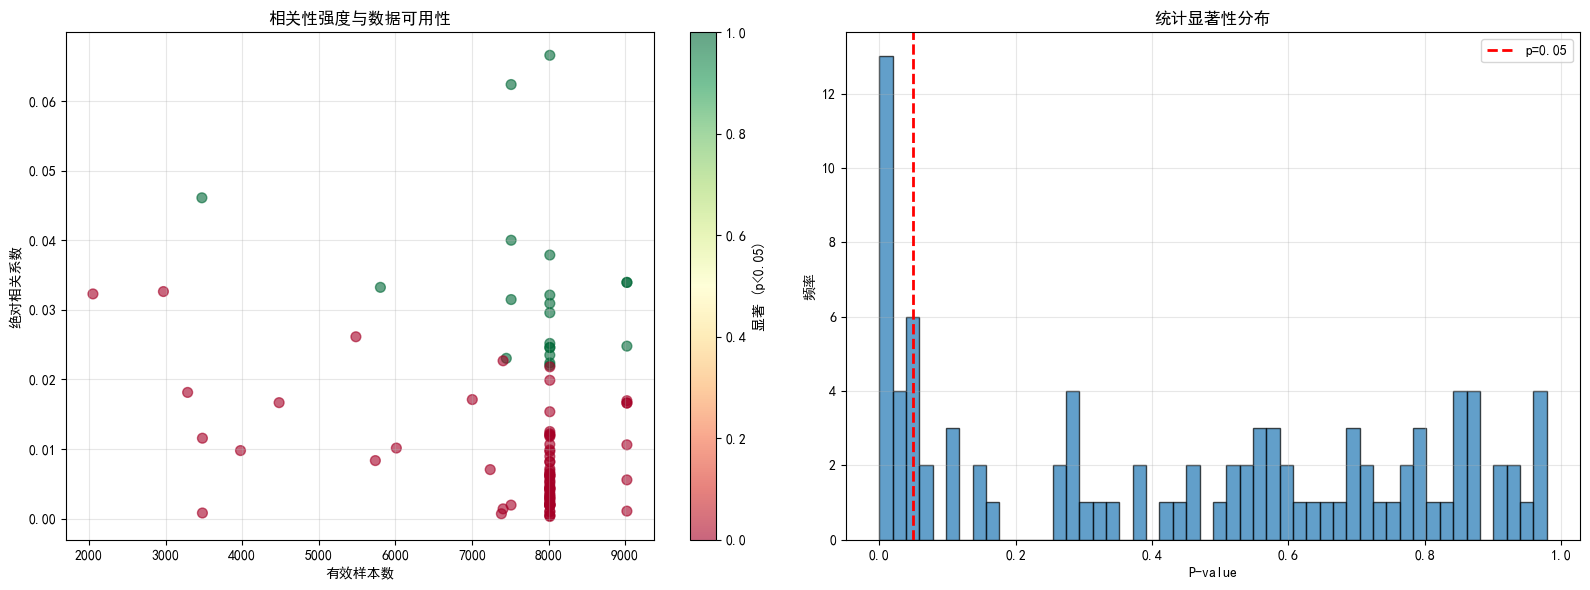

In [140]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
# 相关性与有效样本
ax = axes[0]
scatter = ax.scatter(corr_df['valid_samples'], corr_df['abs_correlation'],
                     c=corr_df['significant'], cmap='RdYlGn', alpha=0.6, s=50)
ax.set_xlabel('有效样本数')
ax.set_ylabel('绝对相关系数')
ax.set_title('相关性强度与数据可用性', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=ax, label='显著 (p<0.05)')
ax.grid(True, alpha=0.3)

# P-value 分布
ax = axes[1]
ax.hist(corr_df['p_value'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0.05, color='red', linestyle='--', linewidth=2, label='p=0.05')
ax.set_xlabel('P-value')
ax.set_ylabel('频率')
ax.set_title('统计显著性分布', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()


 Found 9 regime 特征

 Regime 特征分析:

  D1:
 value  count       pct  mean_return  std_return    sharpe
     0   8736 96.840705    -0.000012    0.010534 -0.017360
     1    285  3.159295     0.002037    0.011124  2.907558

  D2:
 value  count       pct  mean_return  std_return    sharpe
     0   8736 96.840705    -0.000012    0.010534 -0.017360
     1    285  3.159295     0.002037    0.011124  2.907558

  D3:
 value  count       pct  mean_return  std_return   sharpe
     0   8590 95.222259     0.000040    0.010560 0.060231
     1    431  4.777741     0.000315    0.010526 0.475401

  D4:
 value  count       pct  mean_return  std_return    sharpe
     1   5178 57.399401     0.000207    0.010747  0.306239
     0   3843 42.600599    -0.000154    0.010296 -0.238084

  D5:
 value  count       pct  mean_return  std_return    sharpe
     1   1718 19.044452     0.000415    0.010783  0.610680
     0   7303 80.955548    -0.000032    0.010504 -0.048132

  D6:
 value  count       pct  mean_return  std

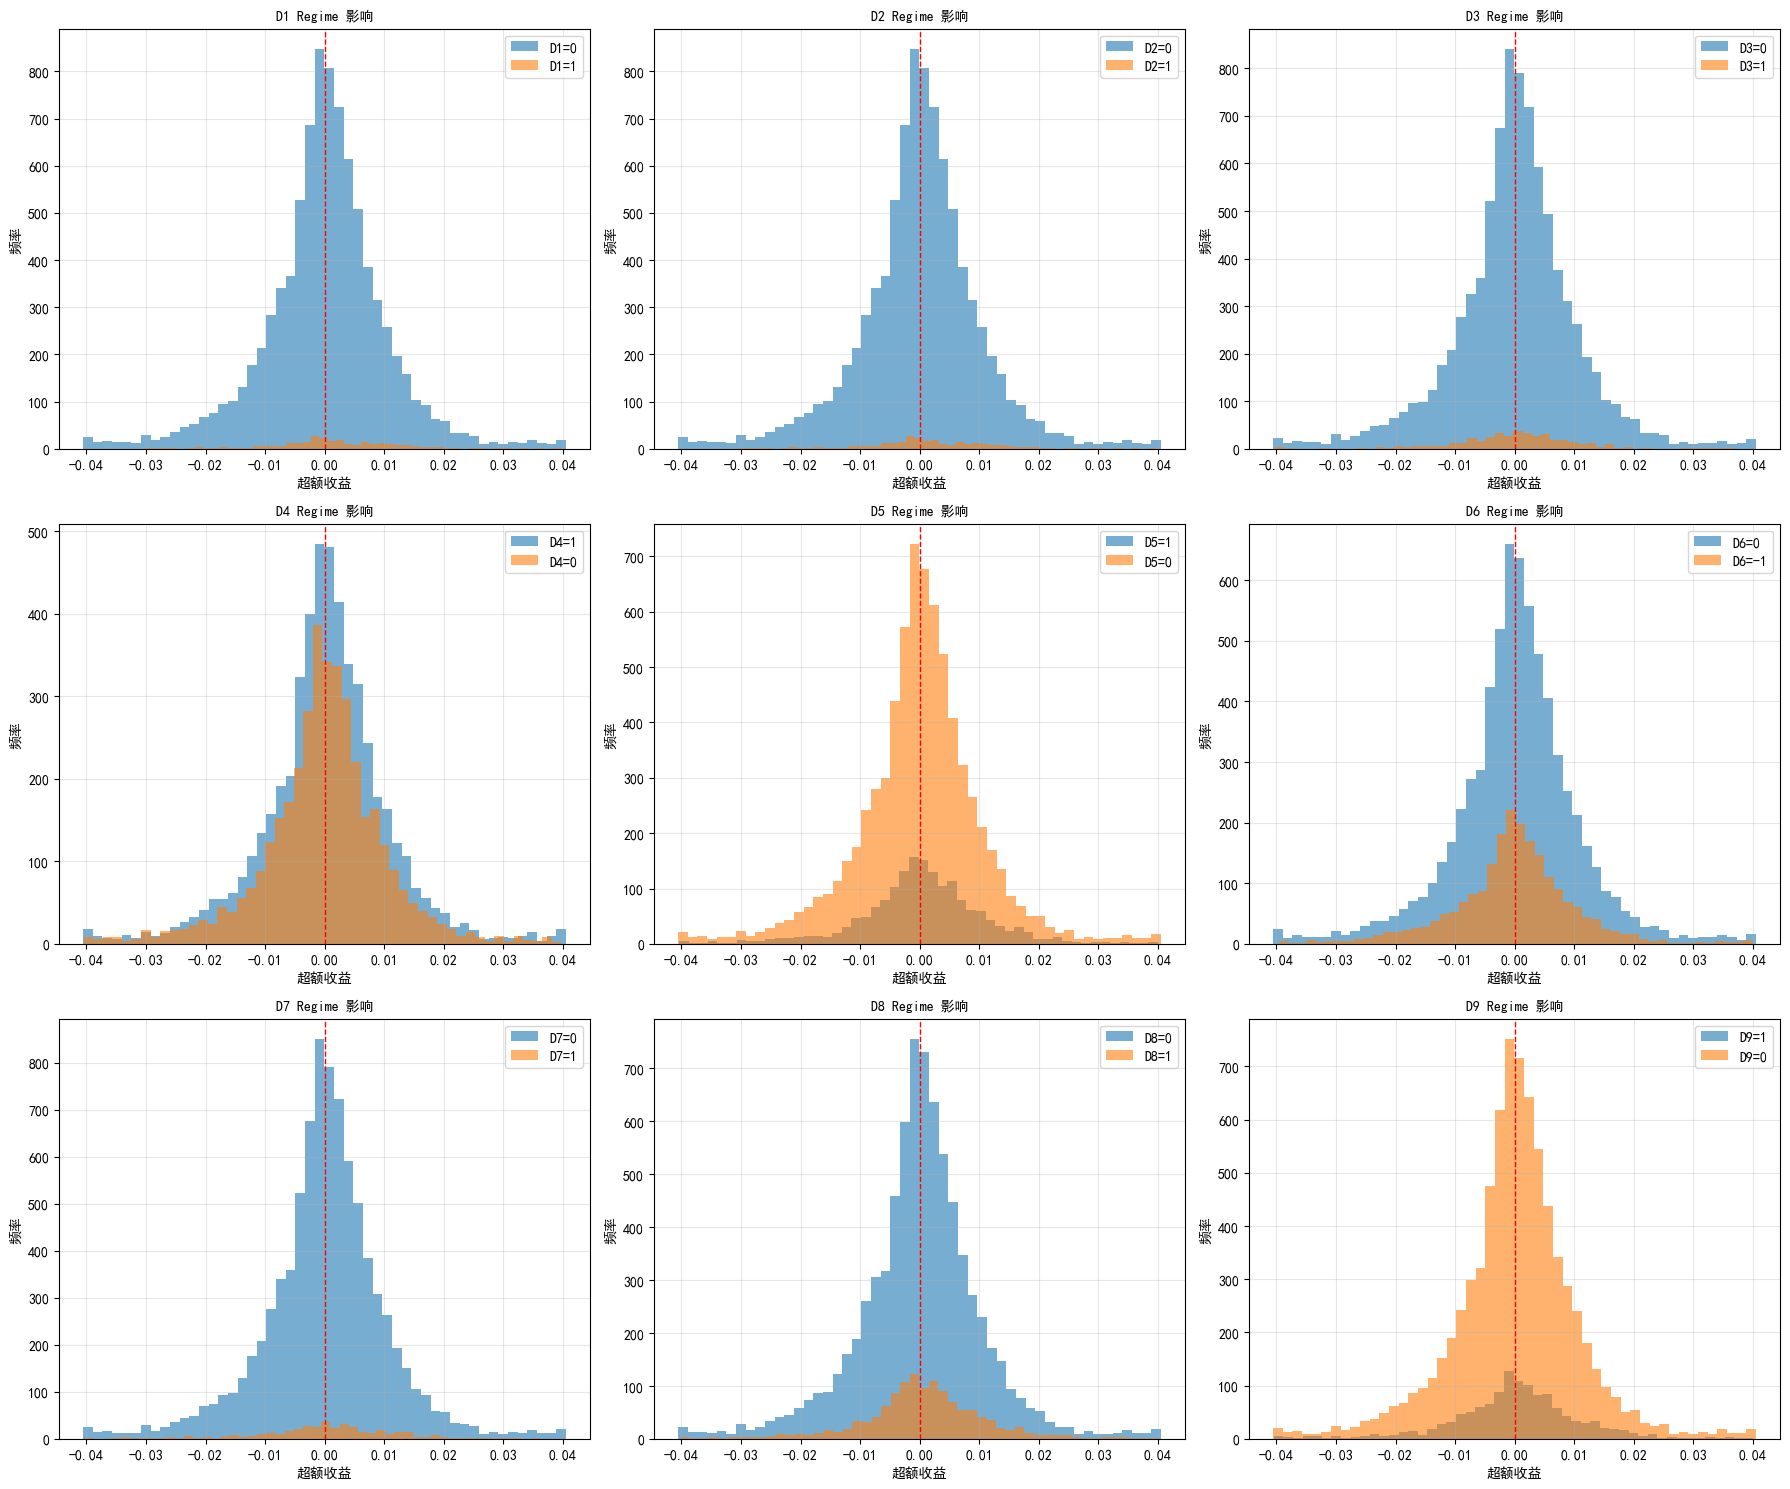

In [141]:
d_cols = [c for c in train.columns if c.startswith('D')]

if len(d_cols) > 0:
    print(f"\n Found {len(d_cols)} regime 特征")

    print(f"\n Regime 特征分析:")
    for col in d_cols:
        unique_vals = train[col].unique()
        value_counts = train[col].value_counts()

        # 计算按 Regime 分组的目标统计
        regime_stats = []
        for val in unique_vals:
            mask = train[col] == val
            regime_returns = train.loc[mask, 'market_forward_excess_returns']
            regime_stats.append({
                'value': val,
                'count': mask.sum(),
                'pct': mask.sum() / len(train) * 100,
                'mean_return': regime_returns.mean(),
                'std_return': regime_returns.std(),
                'sharpe': (regime_returns.mean() / regime_returns.std()) * np.sqrt(252) if regime_returns.std() > 0 else 0
            })

        regime_df = pd.DataFrame(regime_stats)
        print(f"\n  {col}:")
        print(regime_df.to_string(index=False))

    # 可视化 regime 影响
    print("\n 创建 regime 分析可视化...")

    n_regimes = min(len(d_cols), 9)
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()

    for idx, col in enumerate(d_cols[:n_regimes]):
        ax = axes[idx]

        for val in train[col].unique():
            mask = train[col] == val
            regime_data = train.loc[mask, 'market_forward_excess_returns']
            ax.hist(regime_data, bins=50, alpha=0.6, label=f'{col}={val}')

        ax.axvline(0, color='red', linestyle='--', linewidth=1)
        ax.set_xlabel('超额收益')
        ax.set_ylabel('频率')
        ax.set_title(f'{col} Regime 影响', fontsize=10, fontweight='bold')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
else:
    print("⚠ No D (regime) features found")

## 标普500超额收益分布分析

### 1. 市场效率与收益行为

- **日均超额收益**：≈0.00005（接近零）  
- **分布形态**：近似正态，但存在厚尾  
- **结论**：市场高度有效，无系统性套利机会

------

### 2. 尾部风险

- **左尾（亏损）**：实际损失比正态分布预测更严重 → 存在极端下跌风险  
- **右尾（上涨）**：极端上涨亦超出正态预期

------

### 3. 波动率状态分析

| 时期   | 时间范围（交易日） | 年化波动率 | 对应事件       |
| ------ | ------------------ | ---------- | -------------- |
| 危机1  | ~2000–3000         | 30–50%     | 2008年金融危机 |
| 平稳期 | ~3000–6000         | 10–15%     | 2010–2019牛市  |
| 危机2  | ~6000–7000         | 40–55%     | 2020年疫情崩盘 |
| 当前   | ~7000+             | 15–20%     | 疫后恢复期     |

**波动聚集特征**：高波动持续数周至数月  

- **波动上升**：减仓、增现金  
- **波动下降**：逐步加仓  
- **低波动稳定**：适合定投

------

### 4. 累计收益

- 累计收益因子：0.4 – 1.4（起点为1）  
- 出现两次 **40–50%** 的大幅回撤  
- 每次恢复需 **2–4年**

------

### 5. 收益可预测性

- **自相关性**：所有滞后阶数下均≈0  
- **含义**：  
  - 无趋势延续（无动量）  
  - 无均值回归  
  - 无法通过历史价格预测未来收益

------

### 6. 风险-收益关系

- **理论**：高波动应带来高回报  
- **现实**：无明显正相关  
  - 高波动期可能亏损  
  - 低波动期也可能盈利
- **建议**：使用夏普比率等风险调整指标，而非仅看收益

------

### 7. 季节性

- 无显著月度规律  
- “五月卖出”、“一月效应”未被数据支持

------

## 特征相关性分析（共94个特征）

### 1. 按组别汇总相关性

| 组别      | 相关性范围    | 中心值 | 信号强度 |
| --------- | ------------- | ------ | -------- |
| V（波动） | -0.02 ~ +0.06 | ≈0     | 弱正     |
| M（市场） | -0.03 ~ +0.05 | ≈0     | 混合     |
| S（情绪） | -0.02 ~ +0.04 | ≈0     | 弱正     |
| D（状态） | -0.02 ~ +0.03 | ≈0     | 极弱     |
| P（价格） | -0.02 ~ +0.03 | ≈0     | 极弱     |
| E（经济） | -0.03 ~ +0.03 | ≈0     | 可忽略   |
| I（利率） | -0.01 ~ +0.02 | ≈0     | 可忽略   |

→ 所有组别相关性均接近零，无线性预测能力  

------

### 2. 统计显著性

- **p值分布**：近似均匀（0–1）  
- **p < 0.05 的特征**：<10%  
- **多重检验校正后（Bonferroni, p<0.0005）**：几乎无显著特征
  → 多数“显著”结果为假阳性

------

### 3. 数据量 vs 相关性

- **样本少的特征**（<4000）：相关性偏高（0.03–0.05）  
- **样本多的特征**（>8000）：相关性≈0
  → 低样本下的高相关性很可能是虚假信号（小样本噪声、生存偏差、状态依赖）

------

## D类（状态）特征深度分析

9个二元市场状态指标中，部分具有**强预测能力**，夏普比率最高达 **2.91**。

### 1. 关键状态指标表现

| 指标 | 稀有状态 | 频率  | 日均收益 | 夏普 | 信号强度 |
| ---- | -------- | ----- | -------- | ---- | -------- |
| D1   | 1        | 3.2%  | +0.204%  | 2.91 | 🔥 极强   |
| D2   | 1        | 3.2%  | +0.204%  | 2.91 | 🔥 极强   |
| D8   | 1        | 14.3% | +0.070%  | 1.03 | 🔥 强     |
| D7   | 1        | 4.6%  | +0.057%  | 0.77 | ✅ 较强   |
| D5   | 1        | 19.0% | +0.042%  | 0.61 | ✅ 较强   |
| D3   | 1        | 4.8%  | +0.032%  | 0.48 | ⚠️ 中等   |
| D4   | 1        | 57.4% | +0.021%  | 0.31 | ⚠️ 中等   |
| D6   | 0        | 76.2% | +0.015%  | 0.23 | ⚠️ 弱     |
| D9   | 1        | 14.3% | +0.008%  | 0.12 | ❌ 可忽略 |

------

### 2. 高价值信号详解

#### D1 / D2（极强信号）

- **出现频率**：3.2%（≈8天/年）  
- **日均收益**：+0.204%（年化 >50%）  
- **夏普**：2.91  
- **风险水平**：与常态相当（波动≈1.1%）  
- **可能含义**：暴跌后反转、动量突破、恐慌结束

#### D8（强信号）

- **频率**：14.3%（≈36天/年）  
- **日均收益**：+0.070%，夏普=1.03  
- **适用性**：提供较多交易机会

#### D5（稳健动量信号）

- **频率**：19%（≈48天/年）  
- **日均收益**：+0.042%，夏普=0.61  
- **平衡性好**：信号强度与频率兼顾

------

### 3. 警示信号

#### D6（熊市标志）

- **D6 = -1 时**（23.8%时间）：  
  - 日均收益：-0.026%  
  - 夏普：-0.40
    → 应降低风险敞口

#### D4（牛熊分割）

- **D4=1**（57.4%）：温和看涨（+0.021%，夏普=0.31）  
- **D4=0**（42.6%）：温和看跌（-0.015%，夏普=-0.24）
  → 可用于组合倾斜调整

------

### 4. 可视化验证

- D1/D2/D5/D8：状态=1 时收益分布明显右移  
- D6：状态=-1 时明显左移  
- D4：两类状态分布清晰分离

> **核心结论**：
> 连续型特征基本无效，但**离散状态指标（D类）能有效区分市场环境**，具备实战建模价值。

In [142]:
# 检查1：测试数据是否包含滞后特征
if 'lagged_forward_returns' in test.columns:
    print(f"   测试集包含滞后特征（lagged_forward_returns等）")
    print(f"    这意味着我们可以使用测试集中的滞后值")
else:
    print(f"   测试集不包含滞后特征")

# 检查2：检查训练/测试是否重叠
train_max_date = train['date_id'].max()
test_min_date = test['date_id'].min()
print(f"\n  训练集最大date_id: {train_max_date}")
print(f"  测试集最小date_id:  {test_min_date}")
print(f"  间隔: {test_min_date - train_max_date} 天")

if test_min_date > train_max_date:
    print(f"   无时间重叠（测试集在训练集之后）")
else:
    print(f"   警告: 可能存在时间重叠！")

# 检查3：特征值范围
print(f"\n 检查测试特征是否在训练范围内...")
feature_range_issues = []
for col in test.columns:
    if col in train.columns and col not in ['date_id', 'is_scored']:
        train_min, train_max = train[col].min(), train[col].max()
        test_min, test_max = test[col].min(), test[col].max()

        if not pd.isna(test_min) and not pd.isna(train_min):
            if test_min < train_min or test_max > train_max:
                feature_range_issues.append({
                    'feature': col,
                    'train_range': f"[{train_min:.4f}, {train_max:.4f}]",
                    'test_range': f"[{test_min:.4f}, {test_max:.4f}]"
                })

if len(feature_range_issues) > 0:
    print(f"   {len(feature_range_issues)} 个特征在测试集中有超出范围的值")
    print(f"    （这可能表示分布偏移）")
else:
    print(f"   所有测试特征在训练范围内")

   测试集包含滞后特征（lagged_forward_returns等）
    这意味着我们可以使用测试集中的滞后值

  训练集最大date_id: 9020
  测试集最小date_id:  8980
  间隔: -40 天
   警告: 可能存在时间重叠！

 检查测试特征是否在训练范围内...
   所有测试特征在训练范围内


In [143]:
# 增强迪基-富勒检验
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(target[~np.isnan(target)])
print(f"  ADF 统计量: {adf_result[0]:.4f}")
print(f"  P值: {adf_result[1]:.4f}")
print(f"  结果: {'平稳 ✓' if adf_result[1] < 0.05 else '非平稳 ⚠'}")

# 自相关分析
print(f"\n 关键滞后期的自相关性:")
for lag in [1, 5, 21, 63]:
    if len(target) > lag:
        autocorr = pd.Series(target).autocorr(lag=lag)
        print(f"  Lag {lag:3d}: {autocorr:7.4f}")

  ADF 统计量: -17.5318
  P值: 0.0000
  结果: 平稳 ✓

 关键滞后期的自相关性:
  Lag   1: -0.0450
  Lag   5: -0.0233
  Lag  21: -0.0036
  Lag  63:  0.0087


In [144]:
# 选择特征进行详细分析
top_features = corr_df.head(20)['feature'].tolist()
print(f"Analyzing top {len(top_features)} correlated features...")

# 滚动窗口参数
rolling_windows = [63, 126, 252]  # 3个月, 6个月, 1年
window_names = ['3-month', '6-month', '1-year']

# 计算每个特征的滚动相关性
rolling_corr_results = {}

for feature in top_features:
    feature_data = train[feature].values
    target_data = train['market_forward_excess_returns'].values

    # 创建用于滚动计算的DataFrame
    temp_df = pd.DataFrame({
        'feature': feature_data,
        'target': target_data
    })

    rolling_corr_results[feature] = {}

    for window, name in zip(rolling_windows, window_names):
        # 计算滚动皮尔逊相关系数
        rolling_corr = temp_df['feature'].rolling(window=window, min_periods=window//2).corr(temp_df['target'])
        rolling_corr_results[feature][name] = rolling_corr.values

        # 计算滚动斯皮尔曼相关系数（基于秩，更稳健）
        def rolling_spearman(x, y, window):
            result = np.full(len(x), np.nan)
            for i in range(window, len(x)):
                x_window = x[i-window:i]
                y_window = y[i-window:i]
                valid_mask = ~(np.isnan(x_window) | np.isnan(y_window))
                if valid_mask.sum() > window//2:
                    result[i] = spearmanr(x_window[valid_mask], y_window[valid_mask])[0]
            return result

        if name == '3-month':  # 仅对一个窗口计算斯皮尔曼相关系数以节省时间
            rolling_corr_results[feature]['spearman_3m'] = rolling_spearman(
                feature_data, target_data, window
            )

print(f"  ✓ 已计算 {len(rolling_windows)} 个窗口大小的滚动相关性")

Analyzing top 20 correlated features...
  ✓ 已计算 3 个窗口大小的滚动相关性


In [145]:
! pip install ruptures -q
import ruptures as rpt

In [146]:
#  滚动互信息（非线性关系）
# ============================================================================

print("互信息同时捕捉线性与非线性依赖关系...")

def calculate_rolling_mi(feature_data, target_data, window=252, step=21):
    """
    计算特征与目标之间的滚动互信息。

    Parameters:
    - window: 滚动窗口大小（默认252 = 1年）
    - step: 步长以减少计算量（默认21 = 1个月）

    Returns:
    - mi_values: 每个步骤的互信息值数组
    - mi_indices: 对应每个互信息值的索引
    """
    mi_values = []
    mi_indices = []

    for i in range(window, len(feature_data), step):
        x_window = feature_data[i-window:i].reshape(-1, 1)
        y_window = target_data[i-window:i]

        # Remove NaN values
        valid_mask = ~(np.isnan(x_window.flatten()) | np.isnan(y_window))

        if valid_mask.sum() > window//2:
            try:
                mi = mutual_info_regression(
                    x_window[valid_mask],
                    y_window[valid_mask],
                    n_neighbors=5,
                    random_state=42
                )[0]
                mi_values.append(mi)
                mi_indices.append(i)
            except:
                mi_values.append(np.nan)
                mi_indices.append(i)
        else:
            mi_values.append(np.nan)
            mi_indices.append(i)

    return np.array(mi_values), np.array(mi_indices)

# 计算前30个特征的滚动互信息（为计算效率限制为前30个）
rolling_mi_results = {}
mi_features = top_features[:50]

print(f"计算前{len(mi_features)}个特征的滚动互信息（这可能需要一些时间）...")

for i, feature in enumerate(mi_features):
    feature_data = train[feature].values
    target_data = train['market_forward_excess_returns'].values

    mi_values, mi_indices = calculate_rolling_mi(feature_data, target_data)
    rolling_mi_results[feature] = {
        'mi_values': mi_values,
        'mi_indices': mi_indices
    }

    if (i + 1) % 5 == 0:
        print(f"  已处理 {i+1}/{len(mi_features)} 个特征...")

互信息同时捕捉线性与非线性依赖关系...
计算前20个特征的滚动互信息（这可能需要一些时间）...
  已处理 5/20 个特征...
  已处理 10/20 个特征...
  已处理 15/20 个特征...
  已处理 20/20 个特征...


In [147]:
# ============================================================================
#  相关性中的结构性断点检测
# ============================================================================

print("检测特征与目标关系中的结构性变化...")

structural_breaks = {}
RUPTURES_AVAILABLE = False

if RUPTURES_AVAILABLE:
    for feature in mi_features[:30]:  # 分析前30个特征的结构性变化
        # 使用滚动相关性作为断点检测的信号
        rolling_corr = rolling_corr_results[feature]['3-month']

        # 移除用于断点检测的 NaN 值
        valid_mask = ~np.isnan(rolling_corr)
        valid_indices = np.where(valid_mask)[0]
        valid_signal = rolling_corr[valid_mask]

        if len(valid_signal) > 100:
            try:
                # 使用 PELT 算法进行断点检测
                model = rpt.Pelt(model="rbf", min_size=63).fit(valid_signal)
                breaks = model.predict(pen=10)

                # 转换回原始索引
                original_breaks = [valid_indices[min(b, len(valid_indices)-1)] for b in breaks[:-1]]
                structural_breaks[feature] = original_breaks

                print(f"  {feature}: {len(original_breaks)} 个结构性变化被检测到")
            except Exception as e:
                structural_breaks[feature] = []
                print(f"  {feature}: 无法检测断点 ({str(e)[:30]})")
        else:
            structural_breaks[feature] = []
else:
    print("  ⚠ Skipping structural break detection (ruptures not installed)")
    # 简单替代方法：检测相关性的大幅变化
    for feature in mi_features[:30]:
        rolling_corr = rolling_corr_results[feature]['3-month']
        valid_mask = ~np.isnan(rolling_corr)

        if valid_mask.sum() > 100:
            # 计算相关性变化的滚动标准差
            corr_diff = np.abs(np.diff(rolling_corr[valid_mask]))
            threshold = np.nanmean(corr_diff) + 2 * np.nanstd(corr_diff)
            break_points = np.where(corr_diff > threshold)[0]
            structural_breaks[feature] = break_points.tolist()[:10]  # Limit to 10 breaks
            print(f"  {feature}: {len(structural_breaks[feature])} 潜在的结构性变化（简单检测）")

检测特征与目标关系中的结构性变化...
  ⚠ Skipping structural break detection (ruptures not installed)
  M4: 10 潜在的结构性变化（简单检测）
  V13: 10 潜在的结构性变化（简单检测）
  M1: 10 潜在的结构性变化（简单检测）
  S5: 10 潜在的结构性变化（简单检测）
  S2: 10 潜在的结构性变化（简单检测）
  D1: 10 潜在的结构性变化（简单检测）
  D2: 10 潜在的结构性变化（简单检测）
  M2: 10 潜在的结构性变化（简单检测）
  V10: 10 潜在的结构性变化（简单检测）
  E7: 10 潜在的结构性变化（简单检测）
  E11: 10 潜在的结构性变化（简单检测）
  V7: 10 潜在的结构性变化（简单检测）
  E12: 10 潜在的结构性变化（简单检测）
  P8: 10 潜在的结构性变化（简单检测）
  S12: 10 潜在的结构性变化（简单检测）
  I2: 10 潜在的结构性变化（简单检测）
  D8: 10 潜在的结构性变化（简单检测）
  M17: 10 潜在的结构性变化（简单检测）
  M12: 10 潜在的结构性变化（简单检测）
  E19: 10 潜在的结构性变化（简单检测）


In [148]:
# ============================================================================
#  相关性状态分析
# ============================================================================

print("分析高/低相关性状态及其特征...")

regime_analysis = []

for feature in mi_features:
    rolling_corr = rolling_corr_results[feature]['3-month']
    valid_corr = rolling_corr[~np.isnan(rolling_corr)]

    if len(valid_corr) > 100:
        # 定义相关性状态
        corr_mean = np.mean(valid_corr)
        corr_std = np.std(valid_corr)

        high_corr_threshold = corr_mean + 0.5 * corr_std
        low_corr_threshold = corr_mean - 0.5 * corr_std

        # 分类每个时期
        high_corr_periods = valid_corr > high_corr_threshold
        low_corr_periods = valid_corr < low_corr_threshold
        neutral_periods = ~(high_corr_periods | low_corr_periods)

        # 计算状态统计信息
        regime_analysis.append({
            'feature': feature,
            'mean_corr': corr_mean,
            'std_corr': corr_std,
            'high_corr_pct': high_corr_periods.sum() / len(valid_corr) * 100,
            'low_corr_pct': low_corr_periods.sum() / len(valid_corr) * 100,
            'neutral_pct': neutral_periods.sum() / len(valid_corr) * 100,
            'max_corr': np.max(valid_corr),
            'min_corr': np.min(valid_corr),
            'corr_range': np.max(valid_corr) - np.min(valid_corr),
            # 稳定性评分：较低的标准差和范围表示更稳定
            'stability_score': 1 / (1 + corr_std + (np.max(valid_corr) - np.min(valid_corr))/2)
        })

regime_df = pd.DataFrame(regime_analysis)
regime_df = regime_df.sort_values('stability_score', ascending=False)

print(f"\n 特征相关性状态摘要:")
print(regime_df[['feature', 'mean_corr', 'std_corr', 'corr_range', 'stability_score']].to_string(index=False))

分析高/低相关性状态及其特征...

 特征相关性状态摘要:
feature  mean_corr  std_corr  corr_range  stability_score
     S2  -0.119076  0.101521    0.687837         0.691831
    S12   0.013631  0.116065    0.702370         0.681547
    E12   0.000974  0.107608    0.739128         0.676969
     D8   0.024902  0.122659    0.711627         0.676374
     M2   0.037893  0.117150    0.753735         0.669336
    M17  -0.004927  0.111919    0.779485         0.665929
     S5   0.066852  0.115012    0.786668         0.662978
     E7  -0.025499  0.132473    0.765404         0.659990
    E11  -0.013306  0.105538    0.832768         0.657064
    M12  -0.042305  0.118329    0.817338         0.654880
     M4  -0.098181  0.100519    0.892243         0.646563
     I2   0.004401  0.117905    0.868160         0.644336
     D1   0.030184  0.136993    0.877748         0.634571
     D2   0.030184  0.136993    0.877748         0.634571
    V10   0.146034  0.118788    0.948052         0.627820
    E19   0.096560  0.121100    1.008903 

In [149]:
# ============================================================================
#  综合特征稳定性评分
# ============================================================================

# 选择用于详细分析的顶级特征
top_features = corr_df.head(50)['feature'].tolist()

# 将数据分割为多个时期以进行基于时期的分析
n_periods = 5
period_size = len(train) // n_periods

stability_analysis = []

for feature in top_features:
    period_corrs = []
    period_mi = []

    for period in range(n_periods):
        start_idx = period * period_size
        end_idx = (period + 1) * period_size if period < n_periods - 1 else len(train)

        period_data = train.iloc[start_idx:end_idx]
        valid_mask = period_data[feature].notna()

        if valid_mask.sum() > 50:
            # Pearson correlation
            corr, p_val = pearsonr(
                period_data.loc[valid_mask, feature],
                period_data.loc[valid_mask, 'market_forward_excess_returns']
            )
            period_corrs.append(corr)

            # 计算该时期的互信息
            try:
                mi = mutual_info_regression(
                    period_data.loc[valid_mask, feature].values.reshape(-1, 1),
                    period_data.loc[valid_mask, 'market_forward_excess_returns'].values,
                    n_neighbors=5,
                    random_state=42
                )[0]
                period_mi.append(mi)
            except:
                period_mi.append(np.nan)
        else:
            period_corrs.append(np.nan)
            period_mi.append(np.nan)

    # 计算综合稳定性指标
    corr_mean = np.nanmean(period_corrs)
    corr_std = np.nanstd(period_corrs)
    mi_mean = np.nanmean(period_mi)
    mi_std = np.nanstd(period_mi)

    # 检查相关性符号是否一致
    valid_corrs = [c for c in period_corrs if not np.isnan(c)]
    sign_consistency = 1.0 if len(valid_corrs) > 0 and (all(c > 0 for c in valid_corrs) or all(c < 0 for c in valid_corrs)) else 0.0

    # 复合稳定性评分
    # Higher = more stable and predictive
    stability_score = (
        abs(corr_mean) * 0.3 +  # 相关强度
        (1 - min(corr_std, 0.2) / 0.2) * 0.3 +  # 低方差是好的
        sign_consistency * 0.2 +  # 一致的符号是好的
        min(mi_mean, 0.1) / 0.1 * 0.2  # 互信息表示预测能力
    ) if not np.isnan(corr_mean) else 0

    stability_analysis.append({
        'feature': feature,
        'mean_corr': corr_mean,
        'std_corr': corr_std,
        'min_corr': np.nanmin(period_corrs),
        'max_corr': np.nanmax(period_corrs),
        'mean_mi': mi_mean,
        'std_mi': mi_std,
        'sign_consistent': sign_consistency,
        'stability_score': stability_score,
        'periods': period_corrs
    })

stability_df = pd.DataFrame(stability_analysis)
stability_df = stability_df.sort_values('stability_score', ascending=False)
print(stability_df.shape)
print(f"\n 特征稳定性排名（前30个特征）:")
print(stability_df[['feature', 'mean_corr', 'std_corr', 'mean_mi', 'sign_consistent', 'stability_score']].to_string(index=False))

# 识别最稳定和最不稳定的特征
most_stable = stability_df.head(5)['feature'].tolist()
least_stable = stability_df.tail(5)['feature'].tolist()

print(f"\n 稳定性发现:")
print(f"  最稳定的特征: {most_stable}")
print(f"  最不稳定的特征: {least_stable}")

(50, 10)

 特征稳定性排名（前30个特征）:
feature  mean_corr  std_corr  mean_mi  sign_consistent  stability_score
     V9   0.030449  0.025106 0.107727              1.0         0.671476
    V10   0.051606  0.022833 0.089011              1.0         0.659255
     M1   0.055015  0.018044 0.078099              1.0         0.645637
     V7   0.054838  0.037966 0.090780              1.0         0.641063
    V13   0.079851  0.020792 0.070961              1.0         0.634689
     P5  -0.021541  0.006523 0.061862              1.0         0.620401
    M13   0.014549  0.000354 0.050606              1.0         0.605045
    P11  -0.025559  0.020229 0.061428              1.0         0.600179
    M17   0.027487  0.006369 0.048844              1.0         0.596380
    M18  -0.012966  0.006037 0.046649              1.0         0.588133
     M4  -0.066770  0.025399 0.041564              1.0         0.565060
     E9   0.016710  0.016352 0.039670              1.0         0.559824
     V6   0.013443  0.014186 0.03771

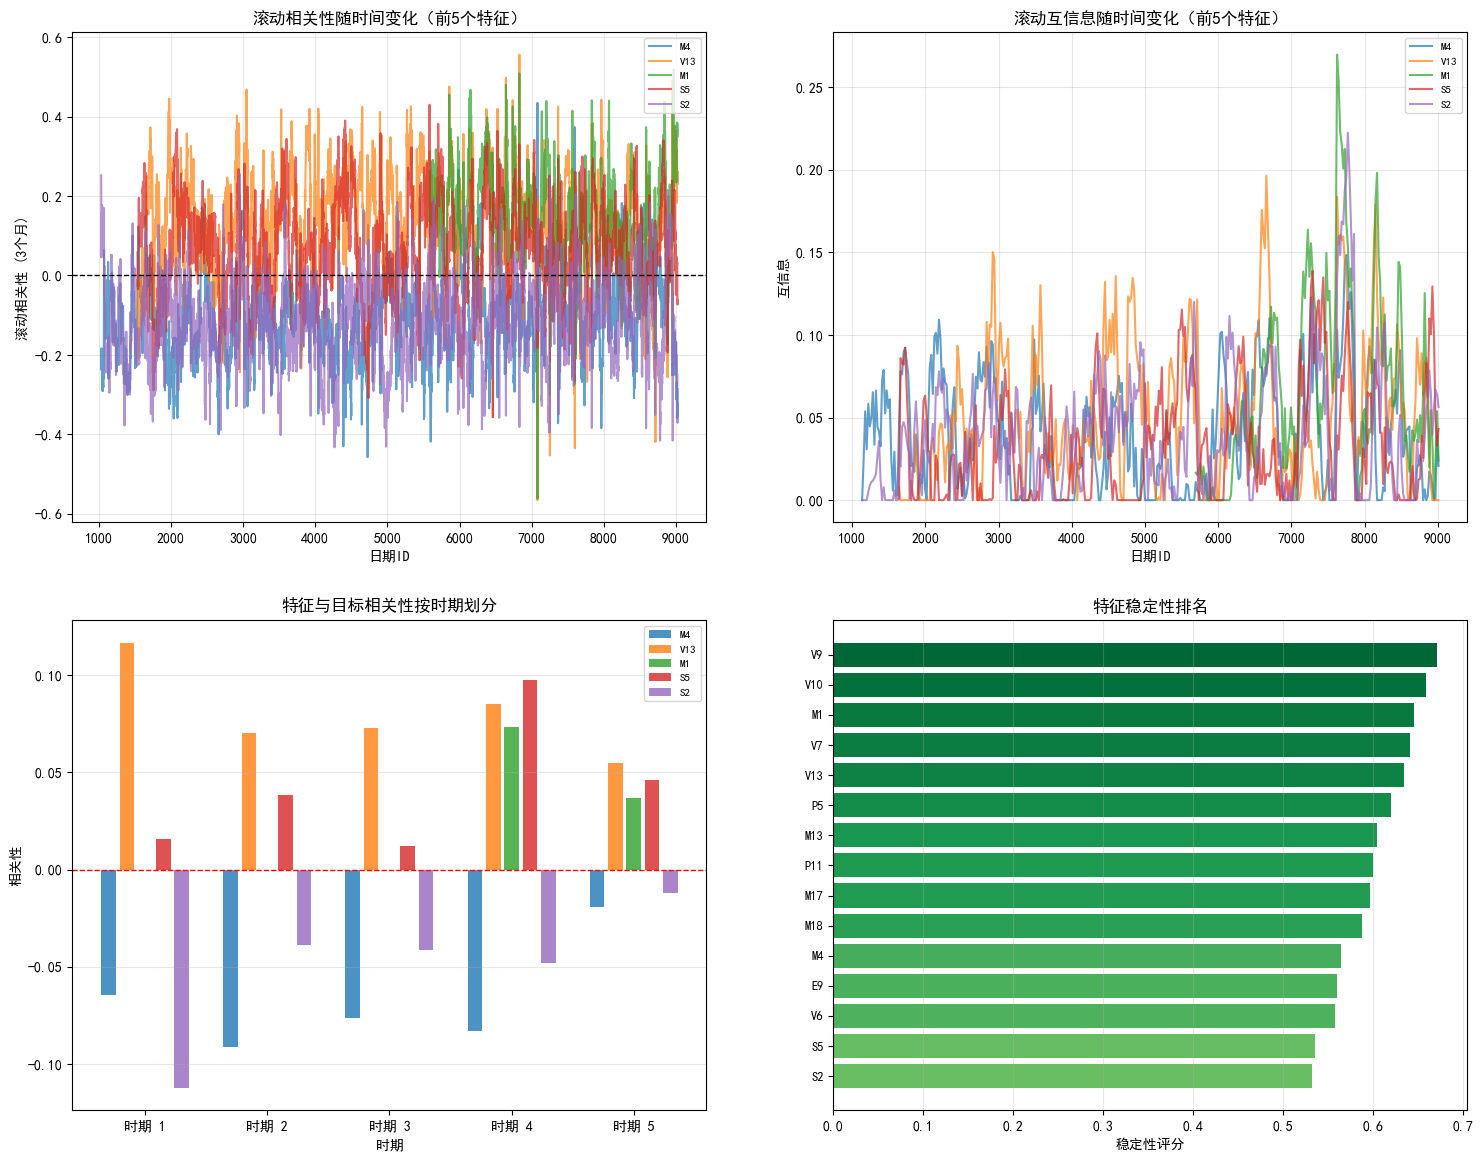

In [150]:
#  可视化：时间变化关系
# ============================================================================

# 图1：滚动相关性热力图
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 子图1：前5个特征随时间推移的滚动相关性
ax = axes[0, 0]
for feature in mi_features[:5]:
    rolling_corr = rolling_corr_results[feature]['3-month']
    ax.plot(train['date_id'].values, rolling_corr, label=feature, alpha=0.7, linewidth=1.5)

ax.axhline(0, color='black', linestyle='--', linewidth=1)
ax.set_xlabel('日期ID')
ax.set_ylabel('滚动相关性 (3个月)')
ax.set_title('滚动相关性随时间变化（前5个特征）', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)

# 子图2：滚动互信息随时间变化
ax = axes[0, 1]
for feature in list(rolling_mi_results.keys())[:5]:
    mi_data = rolling_mi_results[feature]
    ax.plot(mi_data['mi_indices'], mi_data['mi_values'], label=feature, alpha=0.7, linewidth=1.5)

ax.set_xlabel('日期ID')
ax.set_ylabel('互信息')
ax.set_title('滚动互信息随时间变化（前5个特征）', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3)

# 子图3：按时期划分的相关性分布
ax = axes[1, 0]
period_labels = [f'时期 {i+1}' for i in range(n_periods)]
for i, feature in enumerate(mi_features[:5]):
    periods = stability_df[stability_df['feature'] == feature]['periods'].values[0]
    x_positions = np.arange(n_periods) + i * 0.15
    ax.bar(x_positions, periods, width=0.12, label=feature, alpha=0.8)

ax.axhline(0, color='red', linestyle='--', linewidth=1)
ax.set_xlabel('时期')
ax.set_ylabel('相关性')
ax.set_title('特征与目标相关性按时期划分', fontsize=12, fontweight='bold')
ax.set_xticks(np.arange(n_periods) + 0.3)
ax.set_xticklabels(period_labels)
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# 子图4：稳定性评分排名
ax = axes[1, 1]
top_stable = stability_df.head(15)
colors = plt.cm.RdYlGn(top_stable['stability_score'] / top_stable['stability_score'].max())
bars = ax.barh(range(len(top_stable)), top_stable['stability_score'], color=colors)
ax.set_yticks(range(len(top_stable)))
ax.set_yticklabels(top_stable['feature'], fontsize=9)
ax.set_xlabel('稳定性评分')
ax.set_title('特征稳定性排名', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

# Data preprocessing and feature engineering
- 滞后特征构建
- 添加外部数据，增加宏观经济指标，技术指标
- 参数设定

In [151]:
# 构建滞后特征
def create_lag_features(data, lags):
    for lag in lags:
        data[f'lag_{lag}'] = data['market_forward_excess_returns'].shift(lag)
    return data
lags = [1,5,21,63]
train = create_lag_features(train, lags)
print("\n 滞后特征预览:")
print(train.shape)
print(train[[f'lag_{lag}' for lag in lags]].head(10))

# 构建波动率特征
def create_volatility_features(data, windows):
    for window in windows:
        data[f'volatility_{window}'] = data['market_forward_excess_returns'].rolling(window=window).std()
    return data
windows = [5, 21, 63]
train = create_volatility_features(train, windows)
print("\n 波动率特征预览:")
print(train[[f'volatility_{window}' for window in windows]].head(10))



 滞后特征预览:
(9021, 102)
      lag_1     lag_5  lag_21  lag_63
0       NaN       NaN     NaN     NaN
1 -0.003038       NaN     NaN     NaN
2 -0.009114       NaN     NaN     NaN
3 -0.010243       NaN     NaN     NaN
4  0.004046       NaN     NaN     NaN
5 -0.012301 -0.003038     NaN     NaN
6 -0.007066 -0.009114     NaN     NaN
7  0.003029 -0.010243     NaN     NaN
8 -0.025183  0.004046     NaN     NaN
9 -0.009105 -0.012301     NaN     NaN

 波动率特征预览:
   volatility_5  volatility_21  volatility_63
0           NaN            NaN            NaN
1           NaN            NaN            NaN
2           NaN            NaN            NaN
3           NaN            NaN            NaN
4      0.006652            NaN            NaN
5      0.006424            NaN            NaN
6      0.007585            NaN            NaN
7      0.012043            NaN            NaN
8      0.010185            NaN            NaN
9      0.013568            NaN            NaN


# Modeling
- lightbgm
- LSTM
- 融合方法
- 输出每日持仓

In [152]:
! pip install lightgbm -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [153]:
# lightBGM模型训练（补全并添加注释）
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint, uniform as sp_uniform

# 准备训练数据（剔除非特征列）
feature_cols = [c for c in train.columns if c not in ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']]
X = train[feature_cols]
y = train['market_forward_excess_returns']

# 移除包含缺失值的行（因为滞后/波动率特征在开头会有NaN）
# 保持时间顺序：先筛选，再按时间切分
valid_idx = X.notna().all(axis=1) & y.notna()
X_clean = X.loc[valid_idx].reset_index(drop=True)
y_clean = y.loc[valid_idx].reset_index(drop=True)

# 简单的时间序列划分：前80%训练，后20%验证
split = int(len(X_clean) * 0.8)
X_train, X_val = X_clean.iloc[:split], X_clean.iloc[split:]
y_train, y_val = y_clean.iloc[:split], y_clean.iloc[split:]

print(f"训练样本: {X_train.shape}, 验证样本: {X_val.shape}")

# 指定可能的类别特征（以 'D' 开头的常为二元/类别信号）
categorical_features = [c for c in feature_cols if c.startswith('D') and c in X_train.columns]

# 创建LightGBM数据集
lgb_train = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features, free_raw_data=False)
lgb_val = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=lgb_train, free_raw_data=False)

# 设置模型参数
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.05,
    'num_leaves': 31,
    'seed': 42,
    'verbose': -1
}

# 训练模型，使用早停避免过拟合
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train, lgb_val],
                valid_names=['train', 'valid'],
                callbacks=[lgb.early_stopping(50), lgb.log_evaluation(50)])

# 在验证集上进行预测并计算均方误差
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
mse = mean_squared_error(y_val, y_pred)
print(f"验证集 MSE: {mse:.6e}, RMSE: {np.sqrt(mse):.6e}")

# 调参（时间序列随机搜索）

# 使用 scikit-learn 的 LGBMRegressor 便于与 RandomizedSearchCV 配合
lgbm_sk = lgb.LGBMRegressor(objective='regression', random_state=42, n_jobs=-1, verbose=-1)

param_dist = {
    'num_leaves': sp_randint(15, 255),
    'max_depth': sp_randint(3, 15),
    'learning_rate': sp_uniform(0.001, 0.2),
    'n_estimators': sp_randint(100, 2000),
    'min_child_samples': sp_randint(5, 200),
    'subsample': sp_uniform(0.4, 0.6),
    'colsample_bytree': sp_uniform(0.4, 0.6),
    'reg_alpha': sp_uniform(0.0, 1.0),
    'reg_lambda': sp_uniform(0.0, 1.0)
}

tscv = TimeSeriesSplit(n_splits=5)

rs = RandomizedSearchCV(
    estimator=lgbm_sk,
    param_distributions=param_dist,
    n_iter=30,
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rs.fit(X_train, y_train)

print("Best params:", rs.best_params_)
print("Best CV RMSE:", np.sqrt(-rs.best_score_))

# 用最优模型在验证集上评估
best_model = rs.best_estimator_
y_val_pred = best_model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
print(f"验证集 MSE: {mse_val:.6e}, RMSE: {np.sqrt(mse_val):.6e}")

# 把 gbm 变量指向调好的模型以便后续使用
gbm = best_model


训练样本: (1641, 101), 验证样本: (411, 101)
Training until validation scores don't improve for 50 rounds
[50]	train's rmse: 0.00722371	valid's rmse: 0.00935108
Early stopping, best iteration is:
[18]	train's rmse: 0.00925921	valid's rmse: 0.00924876
验证集 MSE: 8.553952e-05, RMSE: 9.248758e-03
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'colsample_bytree': np.float64(0.7367663185416977), 'learning_rate': np.float64(0.1551934359909122), 'max_depth': 9, 'min_child_samples': 31, 'n_estimators': 492, 'num_leaves': 221, 'reg_alpha': np.float64(0.42754101835854963), 'reg_lambda': np.float64(0.02541912674409519), 'subsample': np.float64(0.4647348561959827)}
Best CV RMSE: 0.01169291358960917
验证集 MSE: 8.778941e-05, RMSE: 9.369600e-03


In [154]:
! pip install tensorflow -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [155]:

from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from sklearn.metrics import mean_squared_error

# LSTM 模型预测（序列化特征 -> 训练 -> 预测）

# 固定随机种子
tf.random.set_seed(42)
np.random.seed(42)

# 配置：序列长度（历史天数）
seq_len = 21

# 使用之前清洗好的 X_clean, y_clean 和 split（保持与 LightGBM 相同的时间切分）
X_all = X_clean.values  # X_clean 在之前的 cell 已定义并 reset_index
y_all = y_clean.values
split = int(len(X_clean) * 0.8)  # 与之前保持一致

# 标准化：在训练集上 fit，然后 transform 全部数据
scaler = StandardScaler()
scaler.fit(X_all[:split])
X_all_scaled = scaler.transform(X_all)

# 构建序列（每个样本使用 seq_len 步的特征来预测下一步的 y）
def make_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = make_sequences(X_all_scaled, y_all, seq_len)

# 计算按原来时间切分的序列边界
train_seq_count = max(0, split - seq_len)  # 序列中属于训练集的数量
X_train_seq, y_train_seq = X_seq[:train_seq_count], y_seq[:train_seq_count]
X_val_seq, y_val_seq = X_seq[train_seq_count:], y_seq[train_seq_count:]

print(f"序列样本总数: {len(X_seq)}, 训练序列: {len(X_train_seq)}, 验证序列: {len(X_val_seq)}")
n_features = X_train_seq.shape[2]

# 构建简单 LSTM 模型
model = Sequential([
    LSTM(64, input_shape=(seq_len, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

# 回调
es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# 训练
history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=2
)

# 预测并评估
y_pred_seq = model.predict(X_val_seq).ravel()

mse_lstm = mean_squared_error(y_val_seq, y_pred_seq)
rmse_lstm = np.sqrt(mse_lstm)
print(f"LSTM 验证集 MSE: {mse_lstm:.6e}, RMSE: {rmse_lstm:.6e}")

# 将预测与真实值对齐成 DataFrame（方便后续可视化/比较）
# 序列的目标索引对应原始 y_all 的索引： targets_idx = np.arange(seq_len, seq_len + len(y_seq))
targets_idx = np.arange(seq_len, seq_len + len(y_seq))
val_target_idx = targets_idx[train_seq_count:]

lstm_results = pd.DataFrame({
    'target_index': val_target_idx,
    'y_true': y_val_seq,
    'y_pred': y_pred_seq
})
print(lstm_results.head())

序列样本总数: 2031, 训练序列: 1620, 验证序列: 411
Epoch 1/100
51/51 - 2s - 30ms/step - loss: 0.0266 - val_loss: 0.0105
Epoch 2/100
51/51 - 0s - 6ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 3/100
51/51 - 0s - 5ms/step - loss: 0.0056 - val_loss: 0.0075
Epoch 4/100
51/51 - 0s - 5ms/step - loss: 0.0044 - val_loss: 0.0051
Epoch 5/100
51/51 - 0s - 5ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 6/100
51/51 - 0s - 5ms/step - loss: 0.0022 - val_loss: 0.0039
Epoch 7/100
51/51 - 0s - 5ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 8/100
51/51 - 0s - 6ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 9/100
51/51 - 0s - 6ms/step - loss: 0.0013 - val_loss: 0.0031
Epoch 10/100
51/51 - 0s - 5ms/step - loss: 0.0011 - val_loss: 0.0029
Epoch 11/100
51/51 - 0s - 6ms/step - loss: 9.3034e-04 - val_loss: 0.0020
Epoch 12/100
51/51 - 0s - 6ms/step - loss: 7.5764e-04 - val_loss: 0.0014
Epoch 13/100
51/51 - 0s - 7ms/step - loss: 6.6873e-04 - val_loss: 0.0011
Epoch 14/100
51/51 - 0s - 6ms/step - loss: 6.1586e-04 - val_los

In [156]:
# 简单加权融合两个模型的结果，做出最终预测
# 设定权重（可调整）
w_gbm = 0.6
w_lstm = 0.4

# X_all, split, y_val_pred, lstm_results, valid_idx 均在之前的 cells 已定义
# 构造 LightGBM 在验证集对应的 target_index（与 lstm_results.target_index 对齐）
gbm_df = pd.DataFrame({
    'target_index': np.arange(split, len(X_all)),
    'gbm_pred': y_val_pred
})

# 合并 LSTM 预测（lstm_results 包含 target_index, y_true, y_pred）
merged = gbm_df.merge(lstm_results.rename(columns={'y_pred': 'lstm_pred'}), on='target_index', how='inner')

# 计算加权融合
merged['ensemble'] = w_gbm * merged['gbm_pred'] + w_lstm * merged['lstm_pred']

# 评估：与验证真实值比较（y_true 在 merged 中）
mse_gbm = mean_squared_error(merged['y_true'], merged['gbm_pred'])
mse_lstm = mean_squared_error(merged['y_true'], merged['lstm_pred'])
mse_ens = mean_squared_error(merged['y_true'], merged['ensemble'])

print(f"GBM 验证 RMSE: {np.sqrt(mse_gbm):.6e}")
print(f"LSTM 验证 RMSE: {np.sqrt(mse_lstm):.6e}")
print(f"Ensemble 验证 RMSE: {np.sqrt(mse_ens):.6e}")

# 将结果保存为方便后续使用的变量
y_ensemble = merged['ensemble'].values
ensemble_results = merged[['target_index', 'y_true', 'gbm_pred', 'lstm_pred', 'ensemble']].copy()

# 把融合结果映射回原始 train 行索引和日期
orig_idx_map = np.where(valid_idx)[0]  # 原始 train 中保留的行索引
ensemble_results['orig_row'] = orig_idx_map[ensemble_results['target_index'].values]
ensemble_results['date_id'] = train.loc[ensemble_results['orig_row'], 'date_id'].values

# 显示前几行
ensemble_results.head()

GBM 验证 RMSE: 9.369600e-03
LSTM 验证 RMSE: 9.790896e-03
Ensemble 验证 RMSE: 9.440296e-03


,target_index,y_true,gbm_pred,lstm_pred,ensemble,orig_row,date_id
0,1641,-0.006523,0.000721,-0.000992,0.000036,8610,8610
1,1642,-0.001381,0.000585,-0.000956,-0.000031,8611,8611
2,1643,0.010236,0.000570,-0.000332,0.000210,8612,8612
3,1644,-0.002088,-0.000049,0.000382,0.000123,8613,8613
4,1645,-0.002498,0.000475,0.000072,0.000314,8614,8614


In [157]:
test.tail

<bound method NDFrame.tail of    date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...        V4        V5  \
0     8980   0   0   0   0   1   0   0   1   0  ...  0.828042  0.999172   
1     8981   0   0   0   0   1   0   0   1   0  ...  0.831349  1.120336   
2     8982   0   0   0   0   1   0   0   0   1  ...  0.832672  1.088992   
3     8983   0   0   0   0   1   0   0   0   1  ...  0.835979  1.040988   
4     8984   0   0   0   0   0   0   1   0   1  ...  0.839947  0.944593   
5     8985   0   0   0   0   0   0   0   0   0  ...  0.837963  1.226772   
6     8986   0   0   0   0   0   0   0   0   0  ...  0.837963  0.785877   
7     8987   0   0   1   0   0   0   0   0   0  ...  0.787698  0.834898   
8     8988   0   0   0   0   0   0   0   0   0  ...  0.783730  0.994026   
9     8989   0   0   0   0   0   0   0   0   0  ...  0.783730  1.068037   

         V6        V7        V8        V9  is_scored  lagged_forward_returns  \
0  0.759921 -0.803127  0.170966 -0.751909       True            

In [158]:
# 使用训练好的 LightGBM 和 LSTM 模型对 test 数据进行预测

# 1. LightGBM 预测
# test 需要构造相同的特征（滞后、波动率），并与训练集特征对齐

# 构造与训练集一致的 test 特征并对齐列（避免 KeyError）


# 复用前面定义的函数和参数构建滞后/波动率特征


# 对缺失值处理（与训练集一致，这里简单用全量非缺失行）

# LightGBM 预测

# 2. LSTM 预测
# 标准化（用训练集的 scaler）


# 构造序列特征

    
# LSTM 预测
            

# 3. 融合预测（与验证集相同权重）

# 输出预测结果


In [159]:

# 基于融合预测结果，构建动态仓位分配模型

# Visualising

# Submmiting